In [1]:
import os, gc, sys, h5py, json, math, time
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
from matplotlib import pyplot as plt
from PIL import Image
from os import listdir
from collections import defaultdict
from sklearn.metrics import confusion_matrix
from keras import backend as K
from keras.models import Sequential, Model, load_model
from keras.utils import to_categorical
from keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D
from keras.optimizers import SGD,Adam
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet50 import ResNet50, preprocess_input

c:\users\zaid\anaconda2\envs\tensorflow3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Print size of any object
def memo_obj(obj):
    print(sys.getsizeof(obj)/ 1024**2," MB")

def change_datatype(df):
    int_cols = list(df.select_dtypes(include=['int']).columns)
    for col in int_cols:
        if ((np.max(df[col]) <= 127) and(np.min(df[col] >= -128))):
            df[col] = df[col].astype(np.int8)
        elif ((np.max(df[col]) <= 32767) and(np.min(df[col] >= -32768))):
            df[col] = df[col].astype(np.int16)
        elif ((np.max(df[col]) <= 2147483647) and(np.min(df[col] >= -2147483648))):
            df[col] = df[col].astype(np.int32)
        else:
            df[col] = df[col].astype(np.int64)
    return df

def show_img(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    plt.imshow(img, interpolation='nearest')
    plt.show()

def flip_axis(x, axis):
    x = np.asarray(x).swapaxes(axis, 0)
    x = x[::-1, ...]
    x = x.swapaxes(0, axis)
    return x

def get_class_weights(y):
    counter = Counter(y)
    majority = max(counter.values())
    return  {cls: float(majority/count) for cls, count in counter.items()}

def lgb_modelfit_nocv(params, dtrain, dvalid, predictors, target='target', \
                      objective='multiclass', metrics='multi_logloss', # multi_error\
                      feval=None, early_stopping_rounds=20, num_boost_round=3000, \
                      verbose_eval=250, categorical_features=None):
    lgb_params = {
        'boosting_type': 'gbdt',
        'objective': objective,
        'metric':metrics,
        'learning_rate': 0.01,
        'num_leaves': 30,  # we should let it be smaller than 2^(max_depth)
        'max_depth': -1,  # -1 means no limit
        'min_child_samples': 20,  # Minimum number of data need in a child(min_data_in_leaf)
        'max_bin': 255,  # Number of bucketed bin for feature values
        'subsample': 0.6,  # Subsample ratio of the training instance.
        'subsample_freq': 0,  # frequence of subsample, <=0 means no enable
        'colsample_bytree': 0.3,  # Subsample ratio of columns when constructing each tree.
        'min_child_weight': 5,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
        'subsample_for_bin': 200000,  # Number of samples for constructing bin
        'min_split_gain': 0,  # lambda_l1, lambda_l2 and min_gain_to_split to regularization
        'reg_alpha': 0,  # L1 regularization term on weights
        'reg_lambda': 0,  # L2 regularization term on weights
        'nthread': 8,
        'verbose': 0
    }

    lgb_params.update(params)

    print("preparing validation datasets")

    xgtrain = lgb.Dataset(dtrain[predictors].values, label=dtrain[target].values,
                          feature_name=predictors,
                          categorical_feature=categorical_features)
    
    xgvalid = lgb.Dataset(dvalid[predictors].values, label=dvalid[target].values,
                          feature_name=predictors,
                          categorical_feature=categorical_features)

    evals_results = {}

    bst1 = lgb.train(lgb_params, 
                     xgtrain, 
                     valid_sets=[xgtrain, xgvalid], 
                     valid_names=['train','valid'], 
                     evals_result=evals_results, 
                     num_boost_round=num_boost_round,
                     early_stopping_rounds=early_stopping_rounds,
                     verbose_eval=250, 
                     feval=feval)

    n_estimators = bst1.best_iteration
    print("\nModel Report")
    print("n_estimators : ", n_estimators)
    print(metrics+":", evals_results['valid']['multi_logloss'][n_estimators-1])

    return bst1, evals_results

# Loading in data

In [3]:
base_path = "..\\..\\..\\train_data"
file_path = os.path.join(base_path,"file_labels")
img_path = os.path.join(base_path,"bin-images")
lgb_path = os.path.join(base_path, "lgb_data")

BATCH_SIZE = 32
model_name = "resnet(caffe)_adam_"+str(BATCH_SIZE) + "_random_augment"
dtypes = {'file_name':str, 'label':np.int8, 'sharpness':np.float}

In [4]:
# loading in train data
for i in range(4):
    print("Loading in batch:", i)
    if i == 0:
        df_train = pd.read_csv(lgb_path +'\\' + model_name + '_train_orig_'+str(i)+'.csv', dtype = dtypes)
    else:
        df_train = pd.concat([df_train, pd.read_csv(lgb_path +'\\' + model_name + '_train_orig_'+str(i)+'.csv', dtype = dtypes)])
df_train.shape

Loading in batch: 0
Loading in batch: 1
Loading in batch: 2
Loading in batch: 3


(289536, 2051)

In [5]:
# loading in val and test data
df_val = pd.read_csv(lgb_path +'\\' + model_name + '_val.csv', dtype = dtypes)
df_test = pd.read_csv(lgb_path +'\\' + model_name + '_test.csv', dtype = dtypes)
print(df_val.shape)
print(df_test.shape)

(36192, 2051)
(36192, 2051)


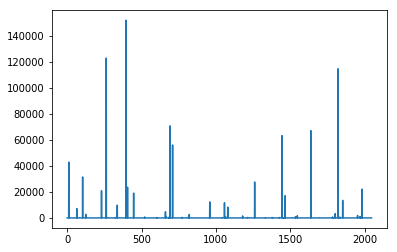

In [6]:
sums = [np.sum(df_train[i]) for i in df_train.columns[:2048]]
plt.plot(range(len(sums)), sums)
plt.show()

# Training LightGBM

In [7]:
sums = pd.Series(sums)
predictors = ['res_clf_' + str(i) for i in sums[sums > 0].index]
predictors += ['sharpness']
target = 'label'

In [8]:
learning_rate = [0.015, 0.02, 0.03]
num_leaves = [11,13,15,17,19, 21]
max_depth = [4,5,6,7]
min_child_samples = [10,20,30,40,50,60]
subsample = [0.7,0.8,0.9]
subsample_freq = [1,1,2,3]
colsample_bytree = [0.2, 0.25, 0.3]
lambda_l1 = [0.01, 0.001, 0.0001]
lambda_l2 = [0.01, 0.001, 0.0001]
max_bin = [250, 350, 450, 550]
num_class = [6,6]

def get_random_params():
    params = {
        'learning_rate': learning_rate[ np.random.randint(len(learning_rate))],
        'num_leaves': num_leaves[np.random.randint(len(num_leaves))],  # we should let it be smaller than 2^(max_depth)
        'max_depth': max_depth[np.random.randint(len(max_depth))],  # -1 means no limit
        'min_child_samples': min_child_samples[np.random.randint(len(min_child_samples))],  # Minimum number of data need in a child(min_data_in_leaf)
        'subsample': subsample[np.random.randint(len(subsample))],  # Subsample ratio of the training instance.
        'subsample_freq': subsample_freq[np.random.randint(len(subsample_freq))],  # frequence of subsample, <=0 means no enable
        'colsample_bytree': colsample_bytree[np.random.randint(len(colsample_bytree))],  # Subsample ratio of columns when constructing each tree.
        'min_child_weight': 0,  # Minimusm sum of instance weight(hessian) needed in a child(leaf)
        'lambda_l1': lambda_l1[np.random.randint(len(lambda_l1))],
        'lambda_l2': lambda_l2[np.random.randint(len(lambda_l2))],
        'max_bin' : max_bin[np.random.randint(len(max_bin))],
        'num_class': num_class[np.random.randint(len(num_class))]
    }
    
    return params

In [ ]:
res = defaultdict(list)

for i in range(300):
    start_time = time.time()
    params = get_random_params()
    
    # make sure that num_leaves are less than 2**max_depth
    if params['num_leaves'] > 2**params['max_depth']:
        params['num_leaves'] = np.random.randint(low = 3, high = 2**params['max_depth'])
    
    for key,val in params.items(): 
        res[key].append(val)
    objective = 'regression' if params['num_class'] == 1 else 'multiclass'
    reg_metrics = ['l1', 'l2'] # Randomly pick l1 for l2
    metrics = reg_metrics[np.random.randint(len(reg_metrics))] if params['num_class'] == 1 else 'multi_logloss'
    
    print("Starting training model", i)
    bst, evals_results = lgb_modelfit_nocv(params, 
                            df_train, 
                            df_val, 
                            predictors, 
                            target, 
                            objective = objective, 
                            metrics = metrics,
                            early_stopping_rounds = 30, 
                            num_boost_round = 1500)
    print("Time taken: ", (time.time() - start_time) / 60, " min")

    label_test_pred = bst.predict(df_test[predictors])
    label_test = df_test.loc[:len(label_test_pred), 'label']
    if params['num_class'] == 1:
        label_test_pred = [np.round(i) for i in label_test_pred]
    else:
        label_test_pred = [np.argmax(label_test_pred[i]) for i in range(label_test_pred.shape[0])]
    conf_mat = confusion_matrix(label_test, label_test_pred)
    for i in range(conf_mat.shape[0]):
        acc = conf_mat[i,i] / np.sum(conf_mat[i, :])
        res['label_'+str(i)+'_acc'].append(acc)
    model_acc = np.sum([conf_mat[i,i] for i in range(conf_mat.shape[0])]) / len(label_test)
    n_estimators = bst.best_iteration
    loss = evals_results['valid'][metrics][n_estimators-1]
    res['test_acc'].append(model_acc)
    res['n_estimators'].append(n_estimators)
    res['loss'].append(loss)
    print("Test acc:", model_acc)
    print("*"*75)
    print()
    
res = pd.DataFrame(res)
res.to_csv('random_search_w_sharpness.csv')
res

Starting training model 0
preparing validation datasets
Training until validation scores don't improve for 30 rounds.
[250]	train's multi_logloss: 1.02657	valid's multi_logloss: 1.09824
[500]	train's multi_logloss: 0.961035	valid's multi_logloss: 1.05454
[750]	train's multi_logloss: 0.946659	valid's multi_logloss: 1.05069
[1000]	train's multi_logloss: 0.939866	valid's multi_logloss: 1.05013
Early stopping, best iteration is:
[1039]	train's multi_logloss: 0.939037	valid's multi_logloss: 1.05011

Model Report
n_estimators :  1039
multi_logloss: 1.0501058900837434
Time taken:  2.3639619827270506  min
Test acc: 0.538986516357206
***************************************************************************

Starting training model 1
preparing validation datasets
Training until validation scores don't improve for 30 rounds.
[250]	train's multi_logloss: 1.04339	valid's multi_logloss: 1.11302
[500]	train's multi_logloss: 0.965431	valid's multi_logloss: 1.05861
[750]	train's multi_logloss: 0.9465

[500]	train's multi_logloss: 0.939309	valid's multi_logloss: 1.05058
Early stopping, best iteration is:
[480]	train's multi_logloss: 0.9402	valid's multi_logloss: 1.05056

Model Report
n_estimators :  480
multi_logloss: 1.0505638992309643
Time taken:  1.061608119805654  min
Test acc: 0.5390417771883289
***************************************************************************

Starting training model 13
preparing validation datasets
Training until validation scores don't improve for 30 rounds.
[250]	train's multi_logloss: 0.989612	valid's multi_logloss: 1.07277
[500]	train's multi_logloss: 0.94618	valid's multi_logloss: 1.05132
[750]	train's multi_logloss: 0.934041	valid's multi_logloss: 1.0502
Early stopping, best iteration is:
[783]	train's multi_logloss: 0.932855	valid's multi_logloss: 1.05004

Model Report
n_estimators :  783
multi_logloss: 1.0500398033924356
Time taken:  2.3197038173675537  min
Test acc: 0.5392628205128205
*********************************************************